## Intro

First we are going to create a synthetic signal with "Ca transients" on top of baseline and next, we are going to detect and reconstruct the events.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import μCats as ucats

Can't load imreg package, affine and homography registrations won't work


## Create synthetic data

In [3]:
np.random.seed(1066)

In [4]:
def alpha_func(t, tau=5.):
    return np.e*(t/tau)*exp(-t/tau)*(t>=0)


from collections import deque
import itertools as itt

def take(N, seq,step=1):
    "Takes first N values from a sequence"
    return list(itt.islice(seq, 0, N, step))


def arma_process(noise, phiv, thetav, c=0):
    p,q = len(phiv),len(thetav)
    buff_ar, buff_ma = deque(),deque()
    for i, n in enumerate(noise):
        upd = n 
        upd += np.sum([phi*b for phi,b in zip(phiv,buff_ar)],0)
        upd += np.sum([th*b for th,b in zip(thetav,buff_ma)],0)
        buff_ar.appendleft(upd)
        buff_ma.appendleft(n)
        if len(buff_ma) > q:
            buff_ma.pop()
        if len(buff_ar) > p: 
            buff_ar.pop()
        if i > p and i > q:
            yield(upd+c)

def make_noise(L,phiv=[0],thetav=[0]):
    proc = arma_process(randn(L+100),phiv,thetav)
    x =  array(take(L, proc))
    return x/std(x)

def make_randomized_events(nevents_range=(3,20), 
                           amp_range=(1.5,3), 
                           tau_range=(5,15),
                           time_range=(20,1900)):
    nevents = randint(*nevents_range)
    def _make_event():
        return dict(time = uniform(*time_range),
                    amp = uniform(*amp_range),
                    tau = uniform(*tau_range))
    events = [_make_event() for i in range(nevents)]
    return events
                  
    
def events_to_signal(tx, events):
    if len(events):
        return np.sum([ev['amp']*alpha_func(tx-ev['time'], ev['tau']) for ev in events],0)
    else:
        return 0*tx
    
def make_noisy_random_events(L=2000,**noise_kwargs):
    txi = arange(L)
    events = make_randomized_events(time_range=(20,L-20))
    noise = make_noise(L,**noise_kwargs)
    return events_to_signal(txi, events)+noise, events

from scipy.fftpack import dct,idct
def synth_baseline(N):
    b = idct(exp(-arange(N))*randn(N))
    b -= amin(b)
    return 1+b

In [5]:
v,events = make_noisy_random_events()

gt = events_to_signal(arange(len(v)), events) # ground truth signal

gt_baseline = 2*synth_baseline(len(v))          # ground truth baseline

v = v + gt_baseline

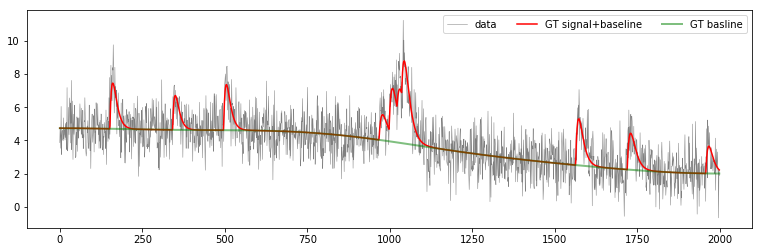

In [6]:
figure(figsize=(13,4))
plot(v,color='gray',label='data',lw=0.5); 
plot(gt+gt_baseline, color='r',label='GT signal+baseline'); 
plot(gt_baseline, color='g',lw=2,alpha=0.5,label='GT basline')
legend(ncol=3)

## Now we are going to reconstruct the events from the "measured" data

In [7]:
%time b_estimate = ucats.multi_scale_simple_baseline(v,smooth_levels=[20,40,80,160])

CPU times: user 28.9 ms, sys: 4.45 ms, total: 33.3 ms
Wall time: 54.6 ms


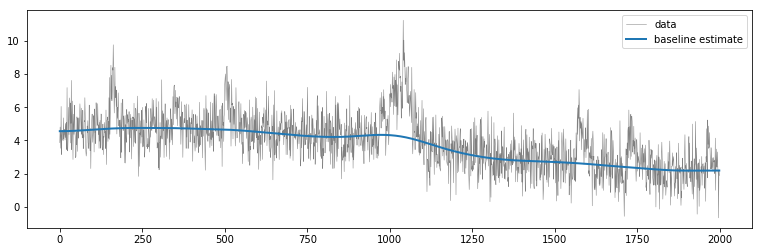

In [8]:
figure(figsize=(13,4))

plot(v, color='gray',lw=0.5,label='data'); plot(b_estimate,color='C0',lw=2,label='baseline estimate')
legend()

In [9]:
y = v-b_estimate

In [10]:
rec = ucats.simple_pipeline_(y, labeler=ucats.simple_label_lj, smoothed_rec=True)

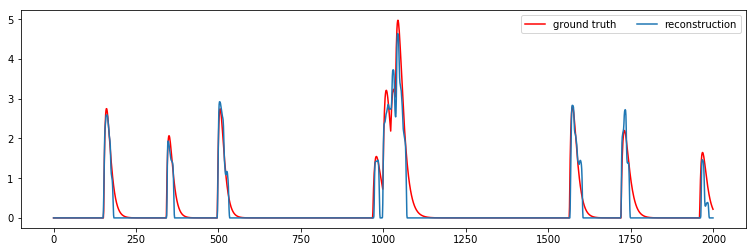

In [11]:
figure(figsize=(13,4))

plot(gt,label='ground truth',c='r'); plot(rec,label='reconstruction')
legend(ncol=2)